In [6]:
import argparse
import os
import math
import random

import torch as th
import torch.distributed as dist
import torchvision as tv
import blobfile as bf
from PIL import Image
import warnings
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
class Arguments(object):
    def __init__(self, dictionary):
        """Constructor"""
        for key in dictionary:
            setattr(self, key, dictionary[key])
            
def read_pil(path, d1=False):
    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
        if d1:
            pil_image = pil_image.convert("L")
        else:
            pil_image = pil_image.convert("RGB")
    return pil_image

In [7]:
def load_imgs(idx, results_path, name=None):
    images_path = os.path.join(results_path, "images")
    classes_path = os.path.join(results_path, "labels")
    samples_path = os.path.join(results_path, "samples")
    
    if name is None:
        img_path = os.listdir(images_path)[idx]
    else:
        img_path = name

    img_pil = read_pil(os.path.join(images_path, img_path))
    clz_pil = read_pil(os.path.join(classes_path, img_path), d1=True)
    smp_pil = read_pil(os.path.join(samples_path, img_path))
    clz_arr = np.array(clz_pil)
    clz_pil_scaled = Image.fromarray(clz_arr/clz_arr.max() * 255.).convert("L")
        
    return img_path, [clz_pil_scaled, clz_pil], [color_class_map(clz_pil), img_pil, smp_pil]

def get_num_images(results_path):
    images_path = os.path.join(results_path, "images")
    classes_path = os.path.join(results_path, "labels")
    samples_path = os.path.join(results_path, "samples")
    
    remove_hidden_directories(images_path)
    remove_hidden_directories(classes_path)
    remove_hidden_directories(samples_path)
    
    
    # assert len(os.listdir(images_path)) == len(os.listdir(classes_path))
    # assert len(os.listdir(images_path)) == len(os.listdir(samples_path))
    
    return len(os.listdir(samples_path))

def display_imgs(imgs, masks=None, titles=[], turing=False, is_sample=False, is_real=False, save=False, filename=None):
    if turing:
        if is_sample:
            rand = 2
        elif is_real:
            rand = 1
        else:
            rand = random.randint(1,2)
        
        imgs = [imgs[0]] + [imgs[rand], imgs[rand]]
        
        
    # Create a figure with four subplots
    fig, axs = plt.subplots(1, len(imgs), figsize=(24, 12))

    # Set different titles for each subplot
    for i, ax in enumerate(axs):
        if len(titles) == len(imgs):
            ax.set_title(str(titles[i]))
        
        
        ax.imshow(imgs[i])
        ax.axis("off")
        
        if masks is not None:
            if masks[i] is not None:
                ax.imshow(masks[i], alpha=0.3)
    
    # Reduce the gap between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    # Show the figure
    if save:
        if filename is not None:
            plt.savefig(filename, dpi=300)
    plt.show()
    
    
def color_class_map(class_map, class_id=0):
    cmap = np.array([[0,0,0],
                     [0, 0, 255], # Blue
                     [255, 0, 0], # Red
                     [255, 128, 0], # Orange
                     [255, 255, 0], # Yellow
                     [0, 255, 0], # Green 
                     [128, 0, 255]]) # Purple
    
    image = np.uint8(np.array(class_map))
    
    if class_id != 0:
        image[image != class_id] = 0
    
    return Image.fromarray(cmap[image].astype(np.uint8))

import os
import shutil

def remove_hidden_directories(folder_path):
    try:
        if os.path.exists(folder_path):
            for item in os.listdir(folder_path):
                item_path = os.path.join(folder_path, item)
                if os.path.isdir(item_path) and item.startswith('.'):
                    shutil.rmtree(item_path)
                    print(f"Removed hidden directory: {item_path}")
            print("Hidden directories removed successfully.")
        else:
            print(f"Folder '{folder_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

Hidden directories removed successfully.
Hidden directories removed successfully.
Hidden directories removed successfully.


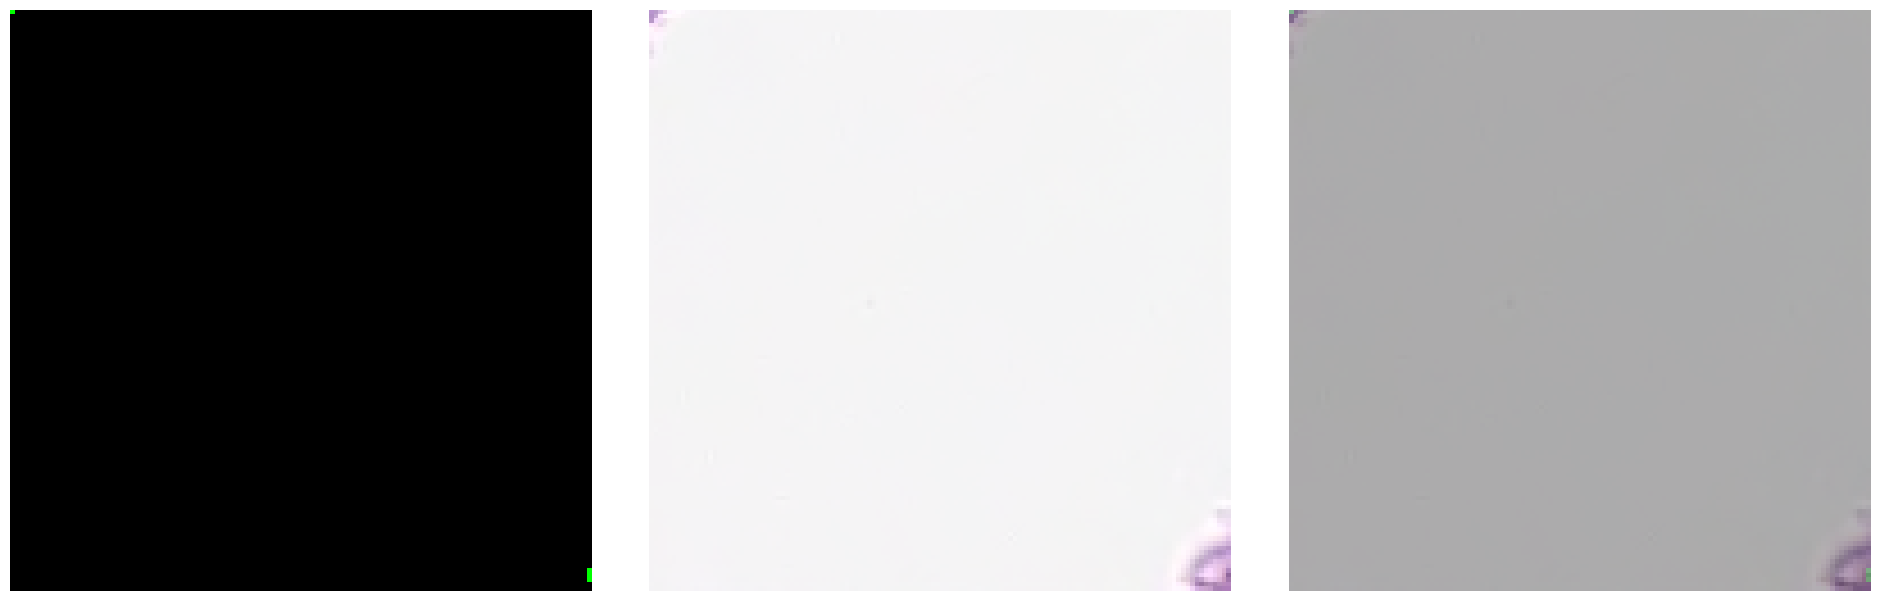

4290.png


In [69]:
## Visualize Random Samples
results_path = "/scratch/as3ek/github/MaskDiff/saves/lr_2e-05__batch_size_64__image_size_128__num_channels_128__num_res_blocks_3__diffusion_steps_1000__noise_schedule_linear/model310000_samples/synthetic160k_nsn_lin/"
# results_path = "/scratch/as3ek/github/NASDM/outputs/lizard_1e4nd80k40bs_2e5nd40bs/samples/syn_test1/"
num_samples = get_num_images(results_path)

idx = random.randint(1, num_samples) - 1
# idx = 0
name, _, smp_zip = load_imgs(idx, results_path)

# display_imgs(smp_zip, masks=[None, None, smp_zip[0]], turing=True, is_sample=True)
display_imgs(smp_zip, masks=[None, None, smp_zip[0]], turing=False, is_sample=True, is_real=True)
# display_imgs(smp_zip, turing=False, is_sample=True)
print(name)

In [200]:
import pandas as pd
results_path = "/scratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/"
df = pd.read_csv('/scratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/review/V2/histo_key_v2.csv', header=None)

assert len(df[1].unique()) == len(df)

for idx, row in df.iterrows():
    sample_no = idx + 1
    
    name = row[1]
    clz = row[0]
    
    _, _, smp_zip = load_imgs(None, results_path, name)
    
    print("Sample: " + str(sample_no))
    
    fname = "sample_" + str(sample_no) + ".png"
    filename = os.path.join(results_path, "review", fname)
    
    if clz == "Real":
        display_imgs(smp_zip, 
                     masks=[None, None, smp_zip[0]], 
                     turing=True, 
                     is_sample=False, 
                     is_real=True, 
                     save=True, 
                     filename=filename)
    if clz == "Fake":
        display_imgs(smp_zip, 
                     masks=[None, None, smp_zip[0]], 
                     turing=True, 
                     is_sample=True, 
                     is_real=False, 
                     save=True, 
                     filename=filename)
    

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [76]:
## Visualize Random Samples from a given class
from tqdm import tqdm
masks = {}
results = {}
names = {}
find_class = 4

for idx in tqdm(range(num_samples-1, -1, -1)):
    nam, msks, res = load_imgs(idx, results_path)
    clz = msks[-1]
    if find_class in list(np.unique(np.array(clz))):
        clzid, clzct = np.unique(np.array(clz), return_counts=True)
        
#         if dict(zip(clzid, clzct))[find_class] > 100:
        masks[idx] = clz
        results[idx] = res
        names[idx] = nam
        
        if len(masks) >= 500:
            break
            

100%|██████████| 640/640 [00:18<00:00, 34.43it/s]


In [230]:
len(masks)

465

crag_49__192_1280.png
Fake


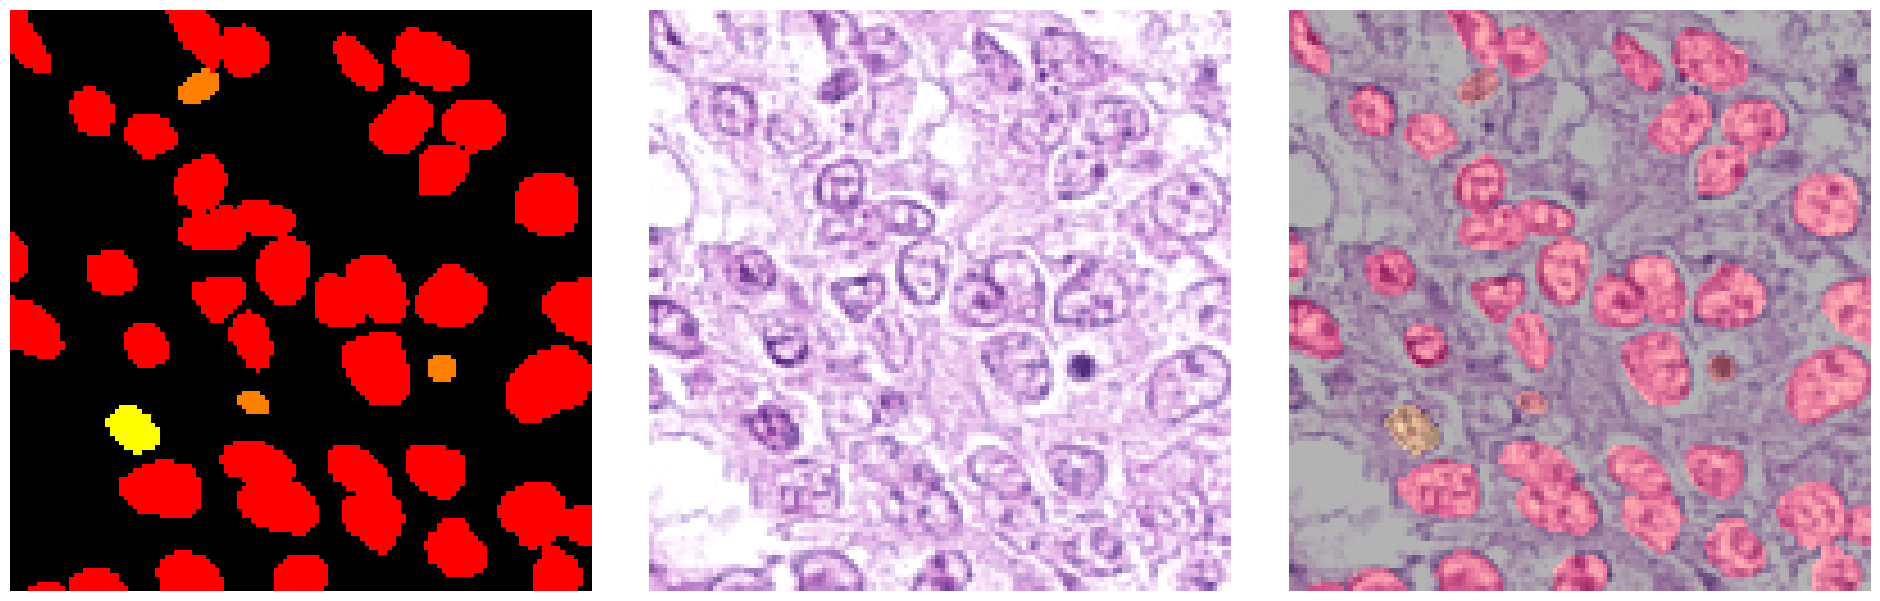

Real


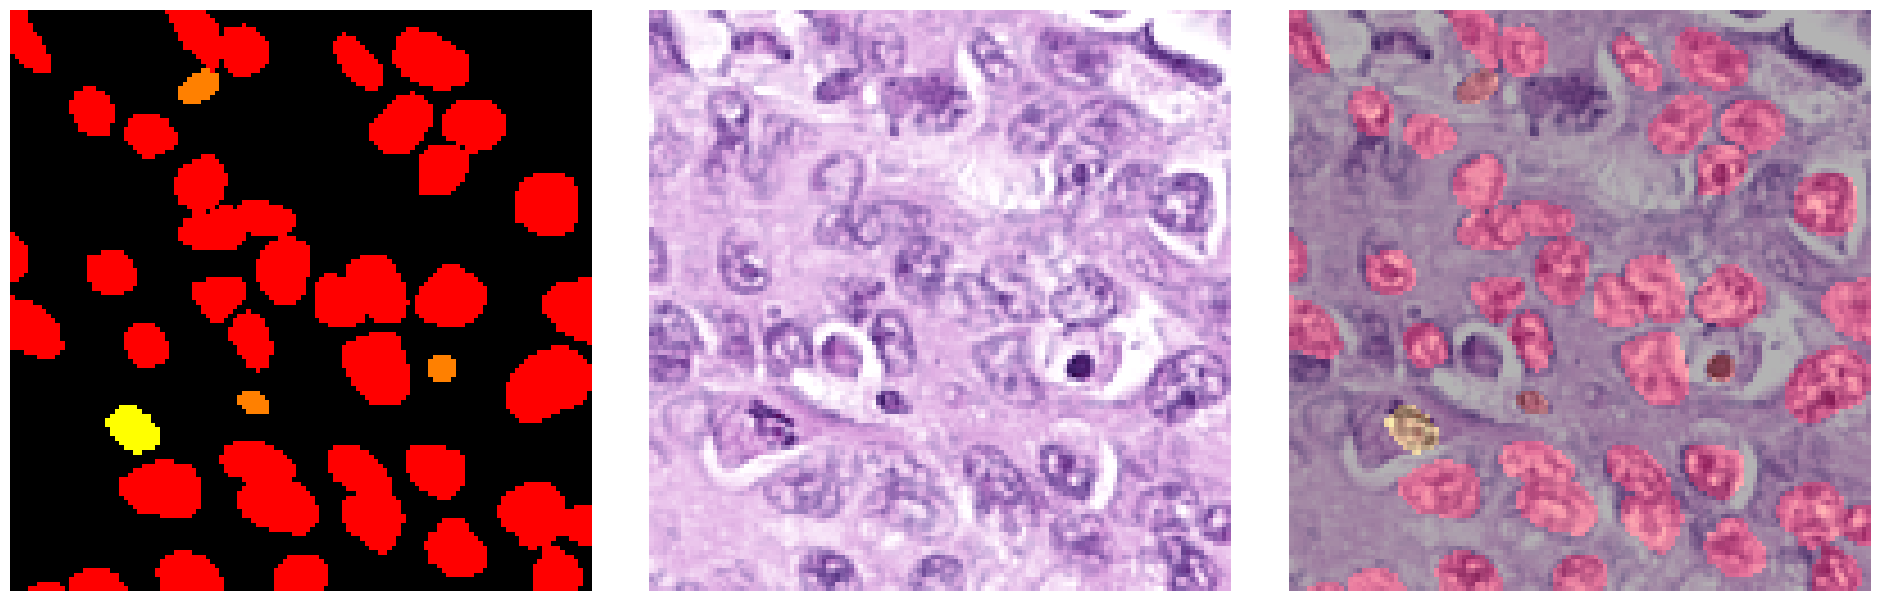

In [255]:
idx = random.randint(1, len(masks)) - 1

msk = masks[list(masks.keys())[idx]]
res = results[list(results.keys())[idx]]
name = names[list(results.keys())[idx]]

# Fake
print(name)
print("Fake")
display_imgs(res, masks=[None, None, res[0]], turing=True, is_sample=True, is_real=False)
# Real
print("Real")
display_imgs(res, masks=[None, None, res[0]], turing=True, is_sample=False, is_real=True)

In [238]:
idx = 4

results_path = "/scratch/as3ek/github/histofusion/outputs/lizard_1e4nd140k_1e4ndnorm215k_2e5ndnormbridr2_bs40/results/val/guidance/"
dirs = os.listdir(results_path)

In [ ]:
results = {}
maps = {}
for fldr in dirs:
    r_path = os.path.join(results_path, fldr)
    maps[fldr], results[fldr] = load_imgs(idx, r_path)

In [ ]:
images = []
import matplotlib.pyplot as plt

os.makedirs("assets/" + str(idx), exist_ok=True)

for key, value in results.items():
    image = value[-1]
    title = str(key)
    
    images.append(image)
    
    image.save("assets/" + str(idx) + "/" + key + ".png")
    value[1].save("assets/" + str(idx) + "/real.png")
    color_class_map(maps[key]).save("assets/" + str(idx) + "/mask.png")
    

images = images + [color_class_map(maps[key]), value[1]] 

In [ ]:
display_imgs(images, titles = list(results.keys()) + ["Mask", "Real Image"])

In [ ]:
# Compute FID
from pytorch_gan_metrics import (
    get_inception_score_from_directory,
    get_fid_from_directory,
    get_inception_score_and_fid_from_directory)


(IS, IS_std), FID = get_inception_score_and_fid_from_directory(
    '/scratch/as3ek/github/histofusion/outputs/lizard256_1e4ndnormbri84k_2e5ndnormbridr2_bs40/results/samples/', 
    '/scratch/as3ek/github/histofusion/outputs/lizard256train_stats.npz', use_torch=False)

(IS, IS_std), FID

In [ ]:
## Get masks of images with all nuclei types
# r_path = "/scratch/as3ek/github/histofusion/outputs/lizard_1e4nd140k_1e4ndnormbri208k_2e5ndnormbridr2_bs40/results/val/guidance/g15/"
# masks = {}
# results = {}
# for idx in range(4000):
#     clz, res = load_imgs(idx, r_path)
#     if len(np.unique(np.array(clz))) == 7:
#         masks[idx] = clz
#         results[idx] = res

# image = results[list(masks.keys())[16]][1]
# image

# msk = masks[list(masks.keys())[16]]
# color_class_map(msk)

# mask_arr = np.array(msk)

# mask_arr[mask_arr != 6] = 0
# color_class_map(Image.fromarray(mask_arr))

In [ ]:
import numpy as np
from skimage.util import random_noise

def add_gaussian_noise(image):
    # Create an array of Gaussian noise
    noise = np.random.normal(0, 1, image.shape)
    # Add noise to image
    noisy_image = image + noise
    # Clip noisy image to range of 0-1
    noisy_image = np.clip(noisy_image, 0, 1)

    return noisy_image

In [ ]:
Image.fromarray((add_gaussian_noise(np.array(image)/255.) * 255).astype(np.uint8))

In [ ]:
def get_edges(t):
    edge = th.ByteTensor(t.size()).zero_()
    edge[:, :, :, 1:] = edge[:, :, :, 1:] | (t[:, :, :, 1:] != t[:, :, :, :-1])
    edge[:, :, :, :-1] = edge[:, :, :, :-1] | (t[:, :, :, 1:] != t[:, :, :, :-1])
    edge[:, :, 1:, :] = edge[:, :, 1:, :] | (t[:, :, 1:, :] != t[:, :, :-1, :])
    edge[:, :, :-1, :] = edge[:, :, :-1, :] | (t[:, :, 1:, :] != t[:, :, :-1, :])
    return edge.float()

In [ ]:
cmask = msk

In [ ]:
import torch
a = torch.tensor(np.array(cmask)).unsqueeze(0).unsqueeze(0)

In [ ]:
Image.fromarray((get_edges(a)[0][0].numpy() * 255.).astype(np.uint8))

In [ ]:
Image.fromarray((get_edges(a)[0][0].numpy() * 255.).astype(np.uint8))

In [ ]:
r_path = "/scratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/"

masks = {}
results = {}
find_class = 5

for idx in range(400):
    _, res = load_imgs(idx, r_path)
    clz = _[-1]
    if find_class in list(np.unique(np.array(clz))):
        clzid, clzct = np.unique(np.array(clz), return_counts=True)
        
        if dict(zip(clzid, clzct))[find_class] > 100:
            masks[idx] = clz
            results[idx] = res
        
    if len(results) >= 100:
        break

In [ ]:
masks

In [ ]:
# image = results[list(masks.keys())[16]][1]
# image

# msk = masks[list(masks.keys())[16]]
# color_class_map(msk)

# mask_arr = np.array(msk)

# mask_arr[mask_arr != 6] = 0
# color_class_map(Image.fromarray(mask_arr))

In [ ]:
idx = 1

msk = masks[list(masks.keys())[idx]]
color_class_map(msk)

In [ ]:
_, image, sample = results[list(masks.keys())[idx]]

In [ ]:
image

In [ ]:
sample